In [2]:
import cv2
import mediapipe as mp
import numpy as np
import math
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return int(angle)

In [4]:
def Euclidean(k,tmp):
    dist= abs(k[1]-tmp[1])**2 + abs(k[0]-tmp[0])**2
    return math.sqrt(dist)

In [24]:
cap = cv2.VideoCapture("C:/Users/Diptanu/Downloads/KneeBendVideo.mp4")
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
writer= cv2.VideoWriter('KneeBendCount.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 25, (width,height))
count=6
angle=180
tmp_angle=180
cin=0
rep=0
timer=0
stat='free'
a_hist=[]
## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        try:
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        except:
            break
        image.flags.writeable = False
        
        # Make detection
        results = pose.process(image)
        
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            # Get coordinates 
            
            left={'hip' : [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y],
              'knee' : [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y],
              'ankle' : [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y],
                 'dist' : landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].z,
                 'viz':  landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].visibility}
            
            right= { 'hip' : [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y],
              'knee' : [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y],
              'ankle' : [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y],
                   'dist' : landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].z,
                   'viz':  landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].visibility}
            
            
            if left['dist']<= right['dist'] and left['viz']>= right['viz']:
                front= left
            else :
                front= right
                
            hip= front['hip']
            knee= front['knee']
            ankle= front['ankle']
            
            if count==6:
                dist=0
                t_kn=knee
            else:
                dist= Euclidean(knee,t_kn)
                tmp_angle= calculate_angle(hip, knee, ankle)
            
            # Calculate angle
            
            if count>=4:                 
                count=0
                if abs(angle-tmp_angle)>=25 or dist>=0.045:
                    cin+=1
                    r=int(255)
                    g=int(0)
                    b=int(0)
                    if cin>8:
                        angle= tmp_angle
                        t_kn=knee
            
                else :
                    angle = tmp_angle
                    r=int(255)
                    g=int(255)
                    b=int(255)
                    t_kn=knee
                    a_hist.append(angle)
                    cin=0
                  
            if angle<140 :
                stat= 'bent'
                timer+=1
            elif 1<timer<200:
                cv2.putText(image, 'Keep your knee bent', (220,520),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
            if stat== 'bent' and timer>200 and angle>140:
                rep+=1
                stat== 'free'
                timer=0
            
            
            # Visualize angle
            cv2.putText(image, str(angle),tuple(np.multiply(knee, [image.shape[1], image.shape[0]]).astype(int)), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            
            cv2.rectangle(image, (0,0), (325,73), (245,117,16), -1)
            
            cv2.putText(image,str(angle),(10,65),cv2.FONT_HERSHEY_SIMPLEX, 1.5, (b,g,r), 2, cv2.LINE_AA)
            
            cv2.putText(image, 'Reps', (135,20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, 'Timer', (235,20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, 'Angle', (10,20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image,str(rep), (135,65),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)
            cv2.putText(image,str(int(timer/25)), (235,65),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)
            
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                     )

            count+=1
                  
        except:
            pass
             
        # Render detections
        writer.write(image)
        cv2.imshow('Mediapipe Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break 
        

    cap.release()
    cv2.destroyAllWindows()

1351


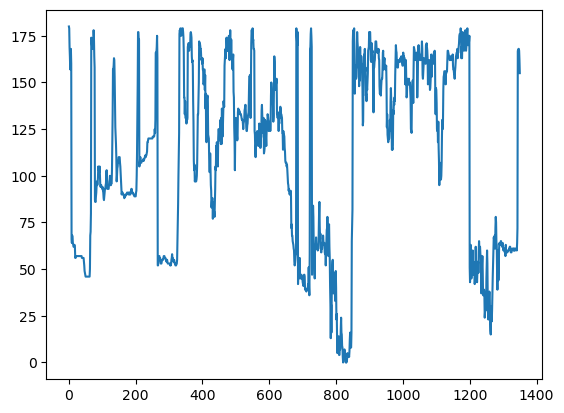

In [21]:
import matplotlib.pyplot as plt
plt.plot(a_hist)
print(len(a_hist))

In [25]:
writer.release()